# Hyperparameter optimization with Dask


Every machine learning model has some values that are specified before training begins. These values help adapt the model to the data but must be given before any training data is seen. For example, this might be `penalty` or `C` in Scikit-learn's [LogisiticRegression]. These values that come before any training data and are called "hyperparameters". Typical usage looks something like:

``` python
from sklearn.linear_model import LogisiticRegression
from sklearn.datasets import make_classification

X, y = make_classification()
est = LogisiticRegression(C=10, penalty="l2")
est.fit(X, y)
```

These hyperparameters influence the quality of the prediction. For example, if `C` is too small in the example above, the output of the estimator will not fit the data well.

Determining the values of these hyperparameters is difficult. In fact, Scikit-learn has an entire documentation page on finding the best values: https://scikit-learn.org/stable/modules/grid_search.html

[LogisiticRegression]:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


Dask enables some new techniques and opportunities for hyperparameter optimization. One of these opportunities involves stopping training early to limit computation. Naturally, this requires some way to stop and restart training (`partial_fit` or `warm_start`  in Scikit-learn parlance).

This is especially useful when the search is complex and has many search parameters. Good examples are most deep learning models, which has specialized algorithms  for  handling  many  data  but  have  difficulty  providing  basic  hyperparameters (e.g., "learning rate", "momentum" or "weight decay").


**This notebook will walk through**

* setting up a realistic example
* how to use `HyperbandSearchCV`, including
    * understanding the input parameters to `HyperbandSearchCV`
    * running the hyperparameter optimization
    * how to access informantion from `HyperbandSearchCV`
    
This notebook will specifically *not* show a performance comparison motivating `HyperbandSearchCV` use. `HyperbandSearchCV` finds high scores with minimal training; however, this is a tutorial on how to *use* it. All performance comparisons are relegated to section [*Learn more*](#Learn-more).

In [1]:
%matplotlib inline

## Setup Dask

In [2]:
from distributed import Client
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

Client Scheduler: inproc://10.20.0.209/14609/1 Dashboard: http://10.20.0.209:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


## Create Data

/home/travis/miniconda/envs/test/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/travis/miniconda/envs/test/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/travis/miniconda/envs/test/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home/travi

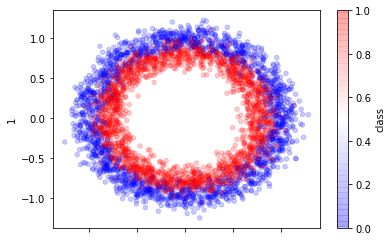

In [3]:
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd

X, y = make_circles(n_samples=30_000, random_state=0, noise=0.09)

pd.DataFrame({0: X[:, 0], 1: X[:, 1], "class": y}).sample(4_000).plot.scatter(
    x=0, y=1, alpha=0.2, c="class", cmap="bwr"
);

### Add random dimensions

In [4]:
from sklearn.utils import check_random_state

rng = check_random_state(42)
random_feats = rng.uniform(-1, 1, size=(X.shape[0], 4))
X = np.hstack((X, random_feats))
X.shape

(30000, 6)

### Split and scale data

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5_000, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
from dask.utils import format_bytes

for name, X in [("train", X_train), ("test", X_test)]:
    print("dataset =", name)
    print("shape =", X.shape)
    print("bytes =", format_bytes(X.nbytes))
    print("-" * 20)

dataset = train
shape = (25000, 6)
bytes = 1.20 MB
--------------------
dataset = test
shape = (5000, 6)
bytes = 240.00 kB
--------------------


Now we have our train and test sets.

## Create model and search space

Let's use Scikit-learn's MLPClassifier as our model (for convenience). Let's use this model with 24 neurons and tune some of the other basic hyperparameters.


In [8]:
import numpy as np
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

Deep learning libraries can be used as well. In particular, [PyTorch]'s Scikit-Learn wrapper [Skorch] works well with `HyperbandSearchCV`.

[PyTorch]:https://pytorch.org/
[Skorch]:https://skorch.readthedocs.io/en/stable/

In [9]:
params = {
    "hidden_layer_sizes": [
        (24, ),
        (12, 12),
        (6, 6, 6, 6),
        (4, 4, 4, 4, 4, 4),
        (12, 6, 3, 3),
    ],
    "activation": ["relu", "logistic", "tanh"],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [16, 32, 64, 128, 256, 512],
}

## Hyperparameter optimization

`HyperbandSearchCV` is Dask-ML's meta-estimator to find the best hyperparameters. It can be used as an alternative to `RandomizedSearchCV` to find similar hyper-parameters in less time by not wasting time on hyper-parameters that are not promising. Specifically, it is almost guaranteed that it will find high performing models with minimal training.

This section will focus on

1. Understanding the input parameters to `HyperbandSearchCV`
2. Using `HyperbandSearchCV` to find the best hyperparameters
3. Seeing other use cases of `HyperbandSearchCV`

In [10]:
from dask_ml.model_selection import HyperbandSearchCV

## Determining input parameters

A rule-of-thumb to determine `HyperbandSearchCV`'s input parameters requires knowing:

1. the number of examples the longest trained model will see
2. the number of hyperparameters to evaluate

Let's write down what these should be for this example:

In [11]:
# For quick response
n_examples = 4 * len(X_train)
n_params = 8

# In practice, HyperbandSearchCV is most useful for longer searches
# n_examples = 15 * len(X_train)
# n_params = 15

In this, models that are trained the longest will see `n_examples` examples. This is how much data is required, normally set be the problem difficulty. Simple problems may only need 10 passes through the dataset; more complex problems may need 100 passes through the dataset.

There will be `n_params` parameters sampled so `n_params` models will be evaluated. Models with low scores will be terminated before they see `n_examples` examples. This helps perserve computation.

How can we use these values to determine the inputs for `HyperbandSearchCV`?

In [12]:
max_iter = n_params  # number of times partial_fit will be called
chunks = n_examples // n_params  # number of examples each call sees

max_iter, chunks

(8, 12500)

This means that the longest trained estimator will see about `n_examples` examples (specifically `n_params * (n_examples // n_params`).

## Applying input parameters

Let's create a Dask array with this chunk size:

In [13]:
import dask.array as da
X_train2 = da.from_array(X_train, chunks=chunks)
y_train2 = da.from_array(y_train, chunks=chunks)
X_train2

dask.array<array, shape=(25000, 6), dtype=float64, chunksize=(12500, 6), chunktype=numpy.ndarray>

Each `partial_fit` call will receive one chunk.

That means the number of exmaples in each chunk should be (about) the same, and `n_examples` and `n_params` should be chosen to make that happen. (e.g., with 100 examples, shoot for chunks with `(33, 33, 34)` examples not `(48, 48, 4)` examples).

Now let's use `max_iter` to create our `HyperbandSearchCV` object:

In [14]:
search = HyperbandSearchCV(
    model,
    params,
    max_iter=max_iter,
    patience=True,
)

## How much computation will be performed?

It isn't clear how to determine how much computation is done from `max_iter` and `chunks`. Luckily, `HyperbandSearchCV` has a `metadata` attribute to determine this beforehand:

In [15]:
search.metadata["partial_fit_calls"]

26

This shows how many `partial_fit` calls will be performed in the computation. `metadata` also includes information on the number of models created.

So far, all that's been done is getting the search ready for computation (and seeing how much computation will be performed). So far, all the computation has been quick and easy.

## Performing the computation

Now, let's do the model selection search and find the best hyperparameters. This is the real core of this notebook. This computation will be take place on all the hardware Dask has available.


In [16]:
%%time
search.fit(X_train2, y_train2, classes=[0, 1, 2, 3])

CPU times: user 3.74 s, sys: 940 ms, total: 4.68 s
Wall time: 3.46 s


HyperbandSearchCV(aggressiveness=3,
                  estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(100,),
                                          learning_rate='constant',
                                          learning_rate_init=0.001,
                                          max_fun=15000, max_iter=200,
                                          momentum=0.9, n_iter_no_change=10,
                                          nesterovs_momentum=True, power_t=0.5,
                                          random_stat...
       9.26759330e-04, 9.33189772e-04, 9.39664831e-04, 9.46184819e-04,
       9.52750047e-04, 9.59360829e-04, 9.66017480e-04, 9.72720319e-04,
       9.79469667e-04, 9.86265846e-04, 9.93109181

The dashboard will be active while this is running. It will show which workers are running `partial_fit` and `score` calls.
This takes about 10 seconds.

## Integration

`HyperbandSearchCV` follows the Scikit-learn API and mirrors Scikit-learn's `RandomizedSearchCV`. This means that it "just works". All the Scikit-learn attributes and methods are available:

In [17]:
search.best_score_

0.8088

In [18]:
search.best_estimator_

MLPClassifier(activation='relu', alpha=0.00012220446866314887, batch_size=32,
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12, 6, 3, 3), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [19]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.head()

,std_score_time,rank_test_score,partial_fit_calls,model_id,params,bracket,std_partial_fit_time,param_alpha,param_hidden_layer_sizes,param_batch_size,mean_score_time,mean_partial_fit_time,param_activation,test_score
0,0.050157,1,6,bracket=1-0,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",1,0.240013,0.000122,"(12, 6, 3, 3)",32,0.053351,0.494750,relu,0.8088
1,0.005329,2,2,bracket=1-1,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",1,0.012428,0.000004,"(12, 12)",128,0.037878,0.772808,tanh,0.5354
2,0.005351,3,2,bracket=1-2,"{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_si...",1,0.089947,0.000217,"(6, 6, 6, 6)",512,0.045663,0.354250,tanh,0.5018
3,0.004681,1,3,bracket=0-0,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",0,0.012882,0.000032,"[4, 4, 4, 4, 4, 4]",64,0.038582,0.544602,logistic,0.5060
4,0.025536,2,3,bracket=0-1,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",0,0.067576,0.000043,"[4, 4, 4, 4, 4, 4]",64,0.033328,0.444151,logistic,0.4940


In [20]:
search.score(X_test, y_test)

0.8096

In [21]:
search.predict(X_test)

dask.array<_predict, shape=(5000,), dtype=int64, chunksize=(5000,), chunktype=numpy.ndarray>

In [22]:
search.predict(X_test).compute()

array([1, 0, 1, ..., 1, 0, 0])

It also has some other attributes.

In [23]:
hist = pd.DataFrame(search.history_)
hist.head()

,model_id,params,partial_fit_calls,partial_fit_time,score,score_time,elapsed_wall_time,bracket
0,bracket=0-0,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",1,0.557483,0.5060,0.033901,0.671414,0
1,bracket=0-1,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",1,0.511727,0.4940,0.058864,0.671416,0
2,bracket=1-0,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",1,0.644579,0.5002,0.037446,0.914875,1
3,bracket=1-1,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",1,0.760380,0.4928,0.043206,0.914877,1
4,bracket=1-2,"{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_si...",1,0.264303,0.5018,0.051014,0.914878,1


This illustrates the history after every `partial_fit` call. There's also an attributed `model_history_` that records the history for each model (it's a reorganization of `history_`).

## Learn more

This notebook covered basic usage `HyperbandSearchCV`. The following documentation and resources might be useful to learn more about `HyperbandSearchCV`, including some of the finer use cases:

* [A talk](https://www.youtube.com/watch?v=x67K9FiPFBQ) introducing `HyperbandSearchCV` to the SciPy 2019 audience and the [corresponding paper](https://conference.scipy.org/proceedings/scipy2019/pdfs/scott_sievert.pdf)
* [HyperbandSearchCV's documentation](https://ml.dask.org/modules/generated/dask_ml.model_selection.HyperbandSearchCV.html)

Performance comparisons can be found in the SciPy 2019 talk/paper.